# Proyecto de Ciencia de Datos
Integrantes: Otto Ferrer y Gema Zambrano

La radiografía de tórax es uno de los estudios de imagen más utilizados en los hospitales para el diagnóstico y seguimiento de múltiples patologías respiratorias y cardiovasculares. Paralelamente, los sistemas hospitalarios almacenan información clínica estructurada que, combinada con imágenes médicas, representa una fuente valiosa para el análisis avanzado de datos.

No obstante, el desarrollo de modelos de inteligencia artificial robustos requiere grandes volúmenes de datos etiquetados, lo cual limita su implementación directa en muchos hospitales. Como alternativa, existen bases de datos públicas de radiografías de tórax que han sido ampliamente utilizadas para el entrenamiento de modelos de aprendizaje profundo.

La problemática central de este proyecto radica en evaluar si un modelo entrenado sobre bases de datos públicas puede ser utilizado de manera efectiva para realizar predicciones sobre radiografías y datos clínicos provenientes de un hospital real, considerando las diferencias en la población, la adquisición de las imágenes y el contexto clínico.

Preguntas del negocio

1.¿En qué medida un modelo entrenado con bases de datos públicas de radiografías de tórax puede identificar hallazgos clínicamente relevantes en datos hospitalarios reales?

2.¿Qué hallazgos torácicos son predichos con mayor y menor confiabilidad por el modelo cuando se aplica a datos hospitalarios?

3.¿Cómo mejora la capacidad predictiva del modelo al integrar radiografías de tórax con variables clínicas, en comparación con el uso exclusivo de imágenes?

4.¿Qué patrones y relaciones emergen entre los hallazgos observados en las radiografías de tórax y las variables clínicas disponibles, y cómo estos patrones pueden orientar el desarrollo y ajuste del modelo predictivo?

5.¿Qué tan interpretable y clínicamente coherente es la información generada por el modelo para apoyar la toma de decisiones en el entorno hospitalario?


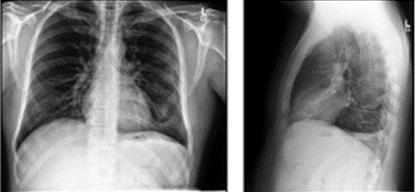

## 1. Cargado de librerias

In [62]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



## 2. Cargado de base de datos

Se requerirá del uso de dos bases de datos de las siguientes caracteristicas:

  a- BD con las etiquetas del hallazgo identificado con las imagenes : dim(223414,19) con 64540 pacientes únicos
  
  b- BD con los datos demográficos de los pacientes: dim(6541,5) con 6541 pacientes únicos 

In [103]:
#1. Carga: etiquetas binarias (0/1) generadas por VisualCheXbert sobre CheXpert.
url2 = "https://github.com/ottoferrer/patient_data/raw/main/train_visualCheXbert.csv"
dataset = pd.read_csv(url2)
dataset = pd.DataFrame(dataset)
dataset.head()
print(dataset.shape)
dataset.columns

(223414, 19)


Index(['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices', 'No Finding'],
      dtype='object')

In [64]:
# 2. Carga: datos demográficos de los pacientes en CheXpert.
url3 = 'https://github.com/ottoferrer/patient_data/raw/main/CHEXPERT%20DEMO.xlsx'
dataset_demo = pd.read_excel(url3, engine='openpyxl')
dataset_demo.head()
#dataset_demo.shape
#pacientes unicos en dataset_demo
#dataset_demo['PATIENT'].nunique()
dataset_demo.columns


Index(['PATIENT', 'GENDER', 'AGE_AT_CXR', 'PRIMARY_RACE', 'ETHNICITY'], dtype='object')

# 3. Preprocesamiento

In [65]:
# dataset contiene informacion en la columna 'Path' por lo que se  separa por cada '/' y obtener  en una nueva columna'
dataset[['version','split','Patient_id','Study','Image']] = dataset['Path'].str.split('/', expand=True)
print(dataset.shape)
dataset.head()

(223414, 24)


,Path,Sex,Age,Frontal/Lateral,AP/PA,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,...,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding,version,split,Patient_id,Study,Image
0,CheXpert-v1.0/train/patient00001/study1/view1_...,Female,68,Frontal,AP,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,CheXpert-v1.0,train,patient00001,study1,view1_frontal.jpg
1,CheXpert-v1.0/train/patient00002/study2/view1_...,Female,87,Frontal,AP,1.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,CheXpert-v1.0,train,patient00002,study2,view1_frontal.jpg
2,CheXpert-v1.0/train/patient00002/study1/view1_...,Female,83,Frontal,AP,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,CheXpert-v1.0,train,patient00002,study1,view1_frontal.jpg
3,CheXpert-v1.0/train/patient00002/study1/view2_...,Female,83,Lateral,NaN,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,CheXpert-v1.0,train,patient00002,study1,view2_lateral.jpg
4,CheXpert-v1.0/train/patient00003/study1/view1_...,Male,41,Frontal,AP,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,CheXpert-v1.0,train,patient00003,study1,view1_frontal.jpg


In [66]:
#Se estan renombrando las columnas del dataset demografico para que coincidan con el dataset principal
dataset_demo = dataset_demo.rename(columns={'PRIMARY_RACE': 'Race'})
dataset_demo = dataset_demo.rename(columns={'PATIENT': 'Patient_id'})
dataset_demo = dataset_demo.rename(columns={'GENDER': 'Sex'})
dataset_demo = dataset_demo.rename(columns={'AGE_AT_CXR': 'Age'})
dataset_demo = dataset_demo.rename(columns={'ETHNICITY': 'Ethnicity'})
dataset_demo.head()



,Patient_id,Sex,Age,Race,Ethnicity
0,patient24428,Male,61,White,Non-Hispanic/Non-Latino
1,patient48289,Female,39,Other,Hispanic/Latino
2,patient33856,Female,81,White,Non-Hispanic/Non-Latino
3,patient41673,Female,42,Unknown,Unknown
4,patient48493,Male,71,White,Non-Hispanic/Non-Latino


## 3.1 Unificación de los set de datos 

In [67]:
#creacion del nuevo dataset uniendo ambos datasets por la columna 'Patient_id'
dataset_demo_l = dataset_demo.drop(['Sex', 'Age'], axis=1)
final_dataset = pd.merge(dataset, dataset_demo_l, on='Patient_id', how='left')
print(final_dataset.shape)
final_dataset.head()


(223414, 26)


,Path,Sex,Age,Frontal/Lateral,AP/PA,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,...,Fracture,Support Devices,No Finding,version,split,Patient_id,Study,Image,Race,Ethnicity
0,CheXpert-v1.0/train/patient00001/study1/view1_...,Female,68,Frontal,AP,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,CheXpert-v1.0,train,patient00001,study1,view1_frontal.jpg,Other,Non-Hispanic/Non-Latino
1,CheXpert-v1.0/train/patient00002/study2/view1_...,Female,87,Frontal,AP,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,CheXpert-v1.0,train,patient00002,study2,view1_frontal.jpg,"White, non-Hispanic",Non-Hispanic/Non-Latino
2,CheXpert-v1.0/train/patient00002/study1/view1_...,Female,83,Frontal,AP,1.0,1.0,1.0,1.0,0.0,...,1.0,0.0,0.0,CheXpert-v1.0,train,patient00002,study1,view1_frontal.jpg,"White, non-Hispanic",Non-Hispanic/Non-Latino
3,CheXpert-v1.0/train/patient00002/study1/view2_...,Female,83,Lateral,NaN,1.0,1.0,1.0,1.0,0.0,...,1.0,0.0,0.0,CheXpert-v1.0,train,patient00002,study1,view2_lateral.jpg,"White, non-Hispanic",Non-Hispanic/Non-Latino
4,CheXpert-v1.0/train/patient00003/study1/view1_...,Male,41,Frontal,AP,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,CheXpert-v1.0,train,patient00003,study1,view1_frontal.jpg,"White, non-Hispanic",Non-Hispanic/Non-Latino


Una vez homologado los nombres de las columnas de los set de datos, se procedió con la creación de un nuevo dataset completo ,el cual incluía la información de los pacientes y de las radiografías: dim(223414,26), 64540 pacientes únicos

## 3.2  Limpieza de valores perdidos

In [68]:
#Revisión de valores nulos en el nuevo dataset
final_dataset.isnull().sum()
#Porcentaje de ruido en cada columna
print(final_dataset.isnull().mean()*100)

#seleccionar solo las filas sin valores nulos
final_dataset_clean = final_dataset.dropna()
final_dataset_clean.isnull().sum()
print(final_dataset_clean.shape)
final_dataset_clean.head()


Path                           0.000000
Sex                            0.000000
Age                            0.000000
Frontal/Lateral                0.000000
AP/PA                         14.496406
Enlarged Cardiomediastinum     0.000000
Cardiomegaly                   0.000000
Lung Opacity                   0.000000
Lung Lesion                    0.000000
Edema                          0.000000
Consolidation                  0.000000
Pneumonia                      0.000000
Atelectasis                    0.000000
Pneumothorax                   0.000000
Pleural Effusion               0.000000
Pleural Other                  0.000000
Fracture                       0.000000
Support Devices                0.000000
No Finding                     0.000000
version                        0.000000
split                          0.000000
Patient_id                     0.000000
Study                          0.000000
Image                          0.000000
Race                           1.077820


,Path,Sex,Age,Frontal/Lateral,AP/PA,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,...,Fracture,Support Devices,No Finding,version,split,Patient_id,Study,Image,Race,Ethnicity
0,CheXpert-v1.0/train/patient00001/study1/view1_...,Female,68,Frontal,AP,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,CheXpert-v1.0,train,patient00001,study1,view1_frontal.jpg,Other,Non-Hispanic/Non-Latino
1,CheXpert-v1.0/train/patient00002/study2/view1_...,Female,87,Frontal,AP,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,CheXpert-v1.0,train,patient00002,study2,view1_frontal.jpg,"White, non-Hispanic",Non-Hispanic/Non-Latino
2,CheXpert-v1.0/train/patient00002/study1/view1_...,Female,83,Frontal,AP,1.0,1.0,1.0,1.0,0.0,...,1.0,0.0,0.0,CheXpert-v1.0,train,patient00002,study1,view1_frontal.jpg,"White, non-Hispanic",Non-Hispanic/Non-Latino
4,CheXpert-v1.0/train/patient00003/study1/view1_...,Male,41,Frontal,AP,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,CheXpert-v1.0,train,patient00003,study1,view1_frontal.jpg,"White, non-Hispanic",Non-Hispanic/Non-Latino
5,CheXpert-v1.0/train/patient00004/study1/view1_...,Female,20,Frontal,PA,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,CheXpert-v1.0,train,patient00004,study1,view1_frontal.jpg,Black or African American,Non-Hispanic/Non-Latino


Se identifica valores perdidos en el 14.49% de la columna AP/PA, 1.07 de raza y 0.45% en ethia reportada. Debido a que la distinción entre AP (Anteroposterior) y PA (Posteroanterior) es crítica en radiología porque cambia la geometría de la imagen. Si no sabes qué proyección estás viendo, es muy fácil cometer errores de diagnóstico, especialmente relacionados con el corazón y el líquido en los pulmones se procede eliminar las observaciones con este faltante.

Dim de la BD post eliminación es de (188828, 26) 


## 3.3 Homologación de las variables categóricas del set de datos

### 3.3.1 Homologación de la Raza

In [101]:
# Revisión de la variable 'Race'
print(final_dataset_clean['Race'].value_counts())

# Estandarizacion de categorias de la variable 'Race'

final_dataset_clean["race_standardized"] = np.nan

# Se normalizan los datos en minúsculas y se eliminan espacios en blanco
final_dataset_clean["race_raw_clean"] = (final_dataset_clean["Race"].str.lower().str.strip())

# White
final_dataset_clean.loc[final_dataset_clean["race_raw_clean"].str.contains("white|caucasian", na=False),
       "race_standardized"] = "White"

# Black or African American
final_dataset_clean.loc[final_dataset_clean["race_raw_clean"].str.contains("black|african", na=False),
       "race_standardized"] = "Black or African American"

# Asian
final_dataset_clean.loc[final_dataset_clean["race_raw_clean"].str.contains("asian", na=False),
       "race_standardized"] = "Asian"

# American Indian or Alaska Native
final_dataset_clean.loc[final_dataset_clean["race_raw_clean"].str.contains("american indian|native american|alaska", na=False),
       "race_standardized"] = "American Indian or Alaska Native"

# Native Hawaiian or Other Pacific Islander
final_dataset_clean.loc[final_dataset_clean["race_raw_clean"].str.contains("hawaiian|pacific islander", na=False),
       "race_standardized"] = "Native Hawaiian or Other Pacific Islander"

# Other
final_dataset_clean.loc[final_dataset_clean["race_raw_clean"].str.contains("^other| other,", regex=True, na=False),
       "race_standardized"] = "Other"

# Unknown / Not Reported
final_dataset_clean.loc[final_dataset_clean["race_raw_clean"].str.contains("unknown|refused", na=False),
       "race_standardized"] = "Unknown / Not Reported"

#revision de los resultados
print(final_dataset_clean['race_standardized'].value_counts())


Race
White                                        86439
Other                                        23175
White, non-Hispanic                          20179
Asian                                        17076
Unknown                                      13520
Black or African American                     8177
Race and Ethnicity Unknown                    7907
Other, Hispanic                               3237
Asian, non-Hispanic                           2518
Native Hawaiian or Other Pacific Islander     2186
Black, non-Hispanic                           1825
White, Hispanic                                861
Other, non-Hispanic                            521
American Indian or Alaska Native               383
Patient Refused                                342
Pacific Islander, non-Hispanic                 290
Native American, non-Hispanic                   51
Black, Hispanic                                 51
Asian, Hispanic                                 34
Native American, Hispanic 

C:\Users\GZAMBRANO\AppData\Local\Temp\ipykernel_12740\3398265273.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dataset_clean["race_standardized"] = np.nan
C:\Users\GZAMBRANO\AppData\Local\Temp\ipykernel_12740\3398265273.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dataset_clean["race_raw_clean"] = (final_dataset_clean["Race"].str.lower().str.strip())
C:\Users\GZAMBRANO\AppData\Local\Temp\ipykernel_12740\3398265273.py:12: FutureWarning: Setting an item of incompatible dtype is deprec

race_standardized
White                                        107479
Other                                         26933
Unknown / Not Reported                        21769
Asian                                         19649
Black or African American                     10053
Native Hawaiian or Other Pacific Islander      2486
American Indian or Alaska Native                459
Name: count, dtype: int64


Se busca a estandarización de categorías reportadas en raza, de 24 categorías encontradas se resumieron en 7 razas

### 3.3.1 Homologación de la Etnia

In [70]:
# Revisión de la variable 'Ethnicity'
print(final_dataset_clean['Ethnicity'].value_counts())

# Estandarizacion de categorias de la variable 'Ethnicity'

final_dataset_clean["ethnicity_standardized"] = np.nan

# Limpiar texto
final_dataset_clean["ethnicity_clean"] = (
    final_dataset_clean["Ethnicity"]
    .str.lower()
    .str.strip()
)
# Hispanic / Latino
final_dataset_clean.loc[
    final_dataset_clean["ethnicity_clean"].str.contains("hispanic|latino", na=False),
    "ethnicity_standardized"
] = "Hispanic / Latino"


# Non-Hispanic 
final_dataset_clean.loc[
    final_dataset_clean["ethnicity_clean"].str.contains("non-hispanic|not hispanic", na=False),
    "ethnicity_standardized"
] = "Non-Hispanic"

# Unknown / Not Reported
final_dataset_clean.loc[
    final_dataset_clean["ethnicity_clean"].str.contains("unknown|patient refused", na=False),
    "ethnicity_standardized"
] = "Unknown / Not Reported"

# 4️⃣ Forzar Unknown si quedó algo sin clasificar
final_dataset_clean["ethnicity_standardized"] = (
    final_dataset_clean["ethnicity_standardized"]
    .fillna("Unknown / Not Reported")
)

#revision de los resultados
print(final_dataset_clean["ethnicity_standardized"].value_counts())


Ethnicity
Non-Hispanic/Non-Latino    138132
Unknown                     28249
Hispanic/Latino             22052
Patient Refused               381
Not Hispanic                   13
Hispanic                        1
Name: count, dtype: int64


C:\Users\GZAMBRANO\AppData\Local\Temp\ipykernel_12740\469120388.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dataset_clean["ethnicity_standardized"] = np.nan
C:\Users\GZAMBRANO\AppData\Local\Temp\ipykernel_12740\469120388.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dataset_clean["ethnicity_clean"] = (
C:\Users\GZAMBRANO\AppData\Local\Temp\ipykernel_12740\469120388.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version 

ethnicity_standardized
Non-Hispanic              138145
Unknown / Not Reported     28630
Hispanic / Latino          22053
Name: count, dtype: int64


C:\Users\GZAMBRANO\AppData\Local\Temp\ipykernel_12740\469120388.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dataset_clean["ethnicity_standardized"] = (


Se busca a estandarización de categorías reportadas en etnia , de 6 categorías encontradas se resumieron en 3 etnias

### 3.3.1 Revisión de la variable sexo

In [71]:
final_dataset_clean.columns
print(final_dataset_clean["Sex"].value_counts())

Sex
Male      110809
Female     78019
Name: count, dtype: int64


No se identificaron homologaciones a realizarse en la variable sexo

# 4. Analisis descriptivo de las variables

## Revisión de diagnosticos según radiografía

### a. RX Posteroanterior- rayos X entra por la espalda y sale por el pecho

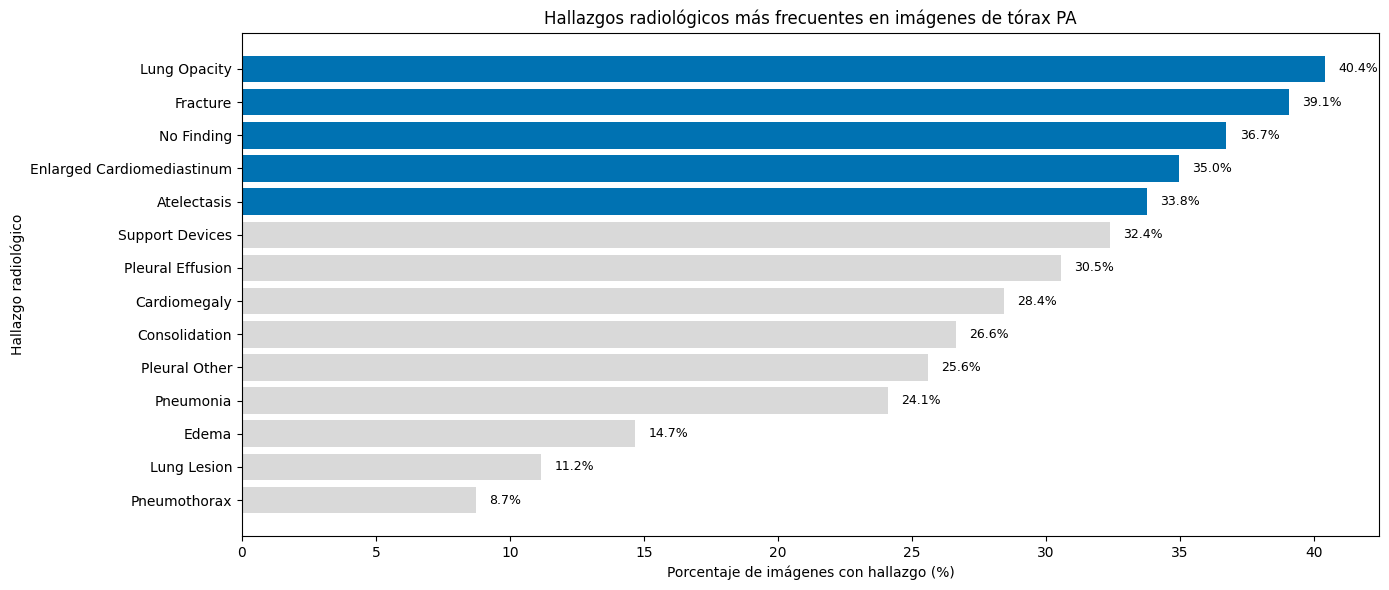

In [106]:
#Porcentaje de cada hallazgo radiológico en imágenes PA

labels = [
    'No Finding',
    'Enlarged Cardiomediastinum',
    'Cardiomegaly',
    'Lung Opacity',
    'Lung Lesion',
    'Edema',
    'Consolidation',
    'Pneumonia',
    'Atelectasis',
    'Pneumothorax',
    'Pleural Effusion',
    'Pleural Other',
    'Fracture',
    'Support Devices'
]
df_1=final_dataset_clean[final_dataset_clean['AP/PA']=='PA']

porcentajes = []
for label in labels:
    porcentaje = (df_1[label] == 1).mean() * 100
    porcentajes.append(porcentaje)

df_porcentajes = pd.DataFrame({
    'label': labels,
    'porcentaje': porcentajes
}).sort_values('porcentaje', ascending=True)  # ascendente para horizontal

top5_labels = df_porcentajes['label'].tail(5).tolist()
colors = ['#0072B2' if label in top5_labels else '#D9D9D9'
          for label in df_porcentajes['label']]

plt.figure(figsize=(14, 6))
bars = plt.barh(
    df_porcentajes['label'],
    df_porcentajes['porcentaje'],
    color=colors
)

plt.xlabel('Porcentaje de imágenes con hallazgo (%)')
plt.ylabel('Hallazgo radiológico')
plt.title('Hallazgos radiológicos más frecuentes en imágenes de tórax PA')

# Etiquetas de porcentaje al final de cada barra
for bar in bars:
    width = bar.get_width()
    plt.annotate(
        f'{width:.1f}%',
        (width + 0.5, bar.get_y() + bar.get_height() / 2),
        va='center',
        ha='left',
        fontsize=9
    )

plt.tight_layout()
plt.show()


In [94]:
#Tabla resumen de conteos por cada etiqueta de los hallazgos radiológicos PA
summary_data = []
for label in labels:
    count_0 = (df_1[label] == 0).sum()
    count_1 = (df_1[label] == 1).sum()
    total = count_0 + count_1
    summary_data.append({
        'Label': label,
        'Count_0': count_0,
        'Count_1': count_1,
        'Total': total
    })
summary_df = pd.DataFrame(summary_data)
print(summary_df)


                         Label  Count_0  Count_1  Total
0                   No Finding    18479    10723  29202
1   Enlarged Cardiomediastinum    18993    10209  29202
2                 Cardiomegaly    20905     8297  29202
3                 Lung Opacity    17404    11798  29202
4                  Lung Lesion    25942     3260  29202
5                        Edema    24916     4286  29202
6                Consolidation    21422     7780  29202
7                    Pneumonia    22164     7038  29202
8                  Atelectasis    19345     9857  29202
9                 Pneumothorax    26655     2547  29202
10            Pleural Effusion    20283     8919  29202
11               Pleural Other    21732     7470  29202
12                    Fracture    17795    11407  29202
13             Support Devices    19751     9451  29202


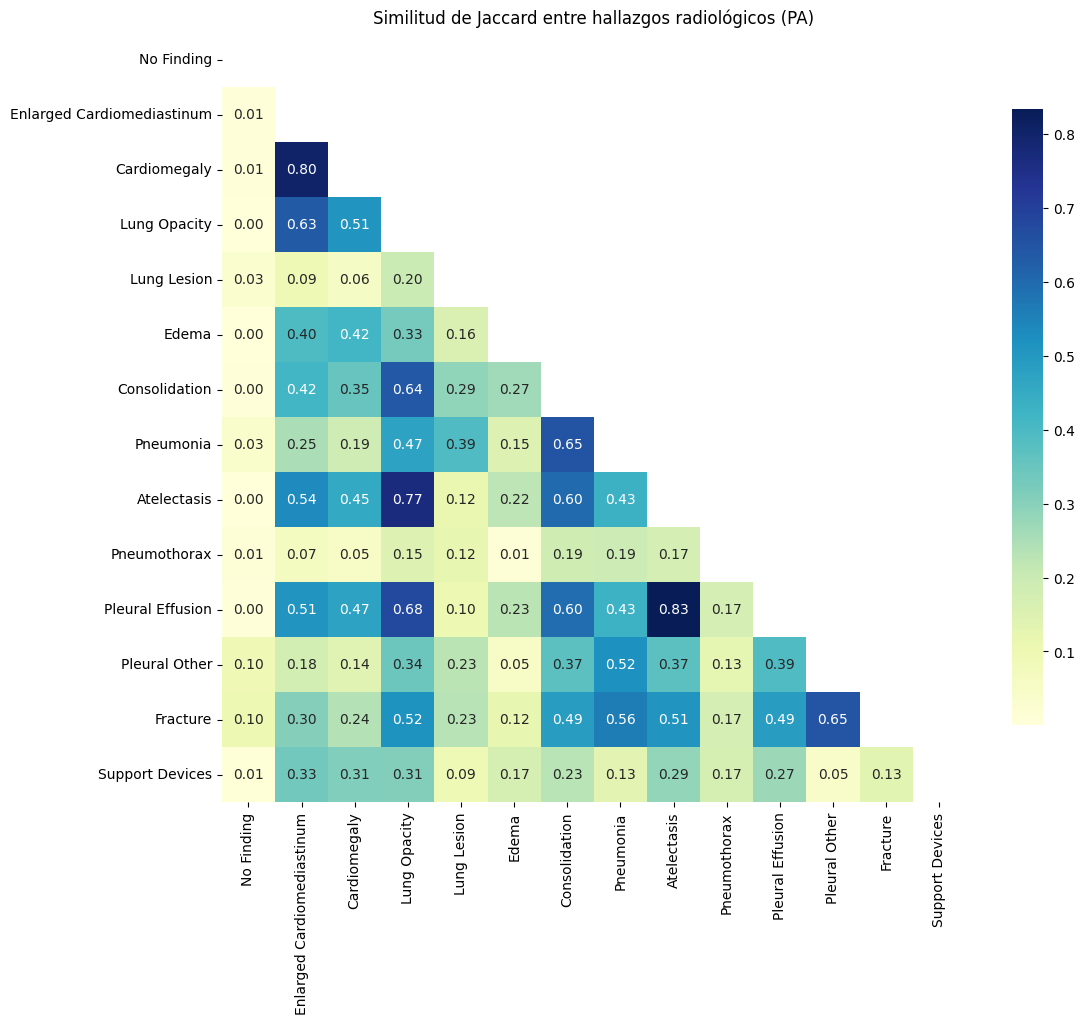

In [100]:
# Analisis de coocurrencias PA
jaccard_matrix = pd.DataFrame(index=labels, columns=labels)

for row_label in labels:
    for col_label in labels:
        if row_label == col_label:
            jaccard_matrix.loc[row_label, col_label] = 1.0
        else:
            # Calculamos Jaccard solo entre estas dos columnas
            y_true = df_1[row_label]
            y_pred = df_1[col_label]
            # average='binary' es clave aquí
            score = jaccard_score(y_true, y_pred, average='binary')
            jaccard_matrix.loc[row_label, col_label] = score

# Convertimos a float para graficar
jaccard_matrix = jaccard_matrix.astype(float)

# Visualización
mask = np.triu(np.ones_like(jaccard_matrix, dtype=bool))
plt.figure(figsize=(12, 10))
sns.heatmap(jaccard_matrix, mask=mask, annot=True, fmt=".2f", cmap='YlGnBu', cbar_kws={"shrink": .8})
plt.title("Similitud de Jaccard entre hallazgos radiológicos (PA)")
plt.show()


El dataset contiene hallazgos radiológicos que no son mutuamente excluyentes y que presentan una jerarquía clínica, por lo que varios de ellos pueden encontrarse relacionados o correlacionados entre sí. En este contexto, se utiliza el índice de Jaccard para medir la similitud entre los distintos hallazgos.

El heatmap de similitud permite visualizar la coexistencia y relación entre los hallazgos radiológicos, evidenciando la presencia de patrones clínicos redundantes o estrechamente asociados, como es el caso de cardiomediastino agrandado y cardiomegalia, ambos relacionados con el agrandamiento del corazón.


### b. RX Posteroanterior- rayos X entra por la espalda y sale por el pecho

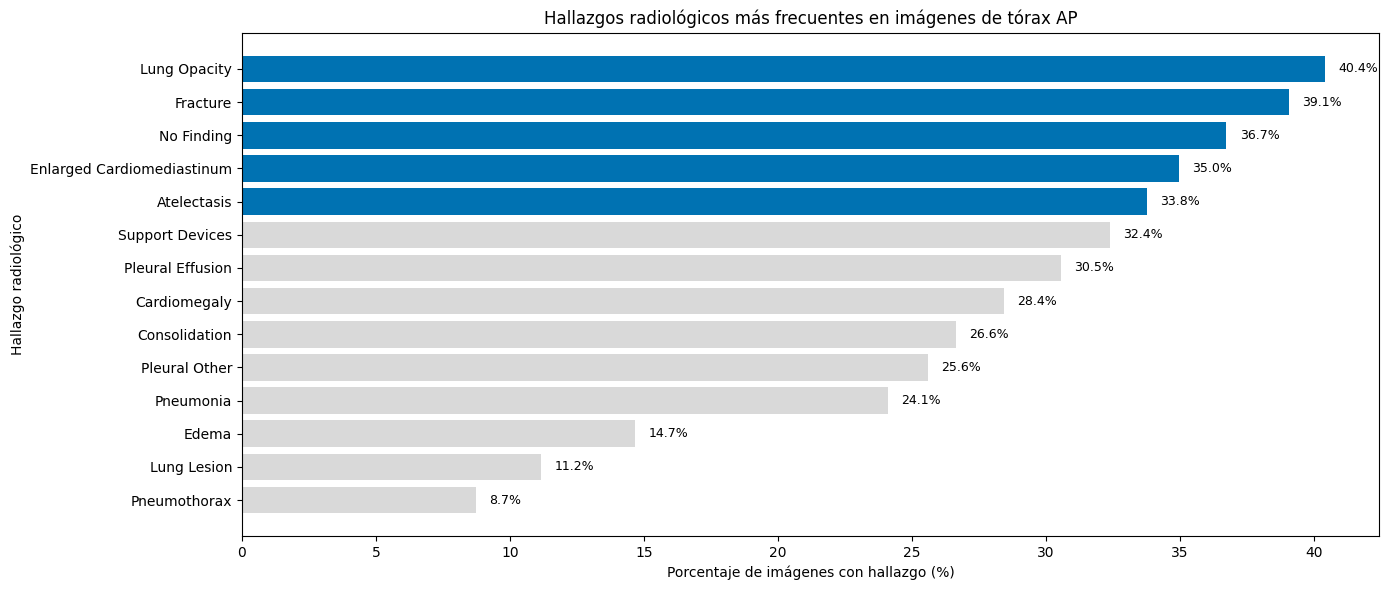

In [105]:
df_2=final_dataset_clean[final_dataset_clean['AP/PA']=='AP']

porcentajes = []
for label in labels:
    porcentaje = (df_1[label] == 1).mean() * 100
    porcentajes.append(porcentaje)

df_porcentajes = pd.DataFrame({
    'label': labels,
    'porcentaje': porcentajes
}).sort_values('porcentaje', ascending=True)  # ascendente para horizontal

top5_labels = df_porcentajes['label'].tail(5).tolist()
colors = ['#0072B2' if label in top5_labels else '#D9D9D9'
          for label in df_porcentajes['label']]

plt.figure(figsize=(14, 6))
bars = plt.barh(
    df_porcentajes['label'],
    df_porcentajes['porcentaje'],
    color=colors
)

plt.xlabel('Porcentaje de imágenes con hallazgo (%)')
plt.ylabel('Hallazgo radiológico')
plt.title('Hallazgos radiológicos más frecuentes en imágenes de tórax AP')

# Etiquetas de porcentaje al final de cada barra
for bar in bars:
    width = bar.get_width()
    plt.annotate(
        f'{width:.1f}%',
        (width + 0.5, bar.get_y() + bar.get_height() / 2),
        va='center',
        ha='left',
        fontsize=9
    )

plt.tight_layout()
plt.show()

In [107]:
#Tabla resumen de conteos por cada etiqueta de los hallazgos radiológicos PA
summary_data = []
for label in labels:
    count_0 = (df_2[label] == 0).sum()
    count_1 = (df_2[label] == 1).sum()
    total = count_0 + count_1
    summary_data.append({
        'Label': label,
        'Count_0': count_0,
        'Count_1': count_1,
        'Total': total
    })
summary_df = pd.DataFrame(summary_data)
print(summary_df)

                         Label  Count_0  Count_1   Total
0                   No Finding   146177    13432  159609
1   Enlarged Cardiomediastinum    40212   119397  159609
2                 Cardiomegaly    57892   101717  159609
3                 Lung Opacity    35775   123834  159609
4                  Lung Lesion   135642    23967  159609
5                        Edema    76485    83124  159609
6                Consolidation    70460    89149  159609
7                    Pneumonia   122671    36938  159609
8                  Atelectasis    58586   101023  159609
9                 Pneumothorax   139599    20010  159609
10            Pleural Effusion    76418    83191  159609
11               Pleural Other   148888    10721  159609
12                    Fracture   122594    37015  159609
13             Support Devices    44947   114662  159609


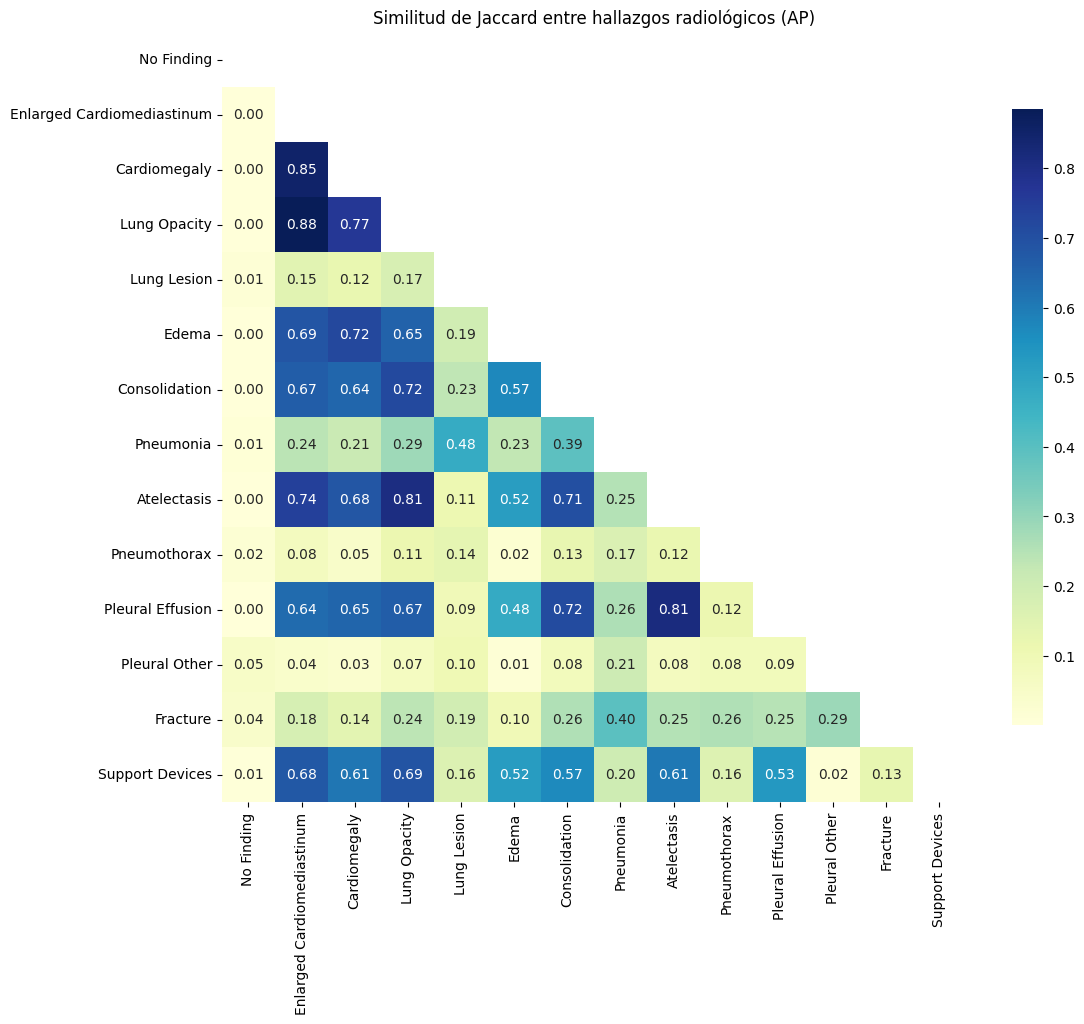

In [109]:
# Analisis de coocurrencias PA
jaccard_matrix = pd.DataFrame(index=labels, columns=labels)

for row_label in labels:
    for col_label in labels:
        if row_label == col_label:
            jaccard_matrix.loc[row_label, col_label] = 1.0
        else:
            # Calculamos Jaccard solo entre estas dos columnas
            y_true = df_2[row_label]
            y_pred = df_2[col_label]
            # average='binary' es clave aquí
            score = jaccard_score(y_true, y_pred, average='binary')
            jaccard_matrix.loc[row_label, col_label] = score

# Convertimos a float para graficar
jaccard_matrix = jaccard_matrix.astype(float)

# Visualización
mask = np.triu(np.ones_like(jaccard_matrix, dtype=bool))
plt.figure(figsize=(12, 10))
sns.heatmap(jaccard_matrix, mask=mask, annot=True, fmt=".2f", cmap='YlGnBu', cbar_kws={"shrink": .8})
plt.title("Similitud de Jaccard entre hallazgos radiológicos (AP)")
plt.show()